<a href="https://colab.research.google.com/github/YYIPL/ML_Project/blob/main/Projet_miniVQA_YIAY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projet :

Vous devez créer un pipeline d'apprentissage automatique, basé sur les réseau de neurones, sur la tâche Visual Question Answering (VQA). Ceci comprend:*
- Creation d'un modèle
- Creation d'un dataloader
- Entraînement selon les splits
- Test sur le split de test
- Ecriture d'un rapport Scientifique

**Creation d'un modèle**

Les images sont de tailles 124x124. Les modèles classiques proposés par pytorch prennent en entrée des images de taille 224x224. <br/>
Nous voulons un modèle qui prennent en entrée les images de tailles 112x112.

Ce modèle encode l'image avec un CNN, et intègre la question dans le pipeline.

**Creation d'un dataloader**
  - sentence embedding (lente forward pass, il est judicieux de calculer cette représentation que une fois sachant que le modèle est pré-entrainé (et fixé).
  - il faut passer d'image 124x124 en 112x112, ceci permet de faire de la data-augmentation (randomresizecrop, randomflip, ...)
  - Le data loader retourne, au moins, la question, l'image et le label

**Entraînement selon les splits**

Il faut créer une procédure d'entrainement et selectionner votre meilleur modèle. Vous aurez surement besoin des methodes torch.save et torch.load pour gérer la sauvegarde de vos modèles.

Pour plus de facilités, vous pouvez directement connecter votre google drive a votre colab.
https://colab.research.google.com/notebooks/io.ipynb

Il y a plein de manières d'améliorer votre entrainement, voici quelques pistes :
  - crop dataloader (image augmentation)
  - dropout
  - Model ensembling
  - Lr scheduler
  - Early stop


 **Pas permis:**<br/>
 - Scale l'image en 224x224 et utiliser un réseau préentrainé


**Ne pas oublier**
- net.train(), net.eval() ne calcule pas les gradients et le dropout

**PS:**
Utiliser adam optimizer comme pour la scéance CNN.

**Test sur le split de test**:
Pour la compétition, il faut reporter la réponse choisie par le modèle (argmax) (cf sample_submission.csv).<br/>
Pour le rapport, il faut reporter l'accuracy top-1 (donnée par le argmax, i.e. cette réponse est elle la bonne réponse) et l'accuracy top-5 (la bonne réponse se trouve-elle dans les 5 plus grandes confiances données par votre modèle? )

**Ecriture d'un rapport Scientifique**

Au minimum, expliquer les points ci-dessus.

**Cela *peut* comprendre**:
- Explorez le jeu de données, donnez des exemples pour quelques classes, la distribution des labels (sous forme de graph ?)
- Quand vous prenez une decision (par exemple, data augementation), montrez visuellement l'effet de cette décision
- Expliquez votre réseau, que sont des convolution et du pooling, mettez des figures, expliquez votre stratégie pour définir la taille des filtres, etc..
- Montrez l'évolution de vos résultats par epoch (sous forme de graph ?), plottez l'accuracy, et la loss. Quelle stratégie d'apprentissage utilisez vous (lr scheduler, early stop, ...)
- Si vous utilisez du dropout, model ensembling, autre technique : explication et effet de cette technique, ...
- **PS: on a surement pas le temps de tout faire ! Concentrez vous sur certains points, et montrez leur impact (qu'il soit négatif ou positif, c'est ca la science...)**

In [1]:
!file=1pfd5-i_F20zViKIYwbQ8jL1p78s_E6uX && wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='${file} -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="${file} -O images.zip && rm -rf /tmp/cookies.txt \
&& unzip -qq images.zip && \
git clone https://github.com/jbdel/miniVQA

--2020-11-10 16:19:54--  https://docs.google.com/uc?export=download&confirm=2Joo&id=1pfd5-i_F20zViKIYwbQ8jL1p78s_E6uX
Resolving docs.google.com (docs.google.com)... 108.177.125.138, 108.177.125.101, 108.177.125.139, ...
Connecting to docs.google.com (docs.google.com)|108.177.125.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-7c-docs.googleusercontent.com/docs/securesc/5736574g78cv8qqfvf9mhuts0upt7hb3/r3bgptvntbs29352afc28htim2hbgdst/1605025125000/06540366866019348016/11806466444255086486Z/1pfd5-i_F20zViKIYwbQ8jL1p78s_E6uX?e=download [following]
--2020-11-10 16:19:55--  https://doc-0c-7c-docs.googleusercontent.com/docs/securesc/5736574g78cv8qqfvf9mhuts0upt7hb3/r3bgptvntbs29352afc28htim2hbgdst/1605025125000/06540366866019348016/11806466444255086486Z/1pfd5-i_F20zViKIYwbQ8jL1p78s_E6uX?e=download
Resolving doc-0c-7c-docs.googleusercontent.com (doc-0c-7c-docs.googleusercontent.com)... 74.125.23.132, 2404:6800:4008:c02::84
Connect

In [2]:
!ls && ls -d miniVQA/*

image124  images.zip  miniVQA  sample_data
miniVQA/answer_list.txt      miniVQA/sample_submission.csv  miniVQA/val.csv
miniVQA/image_question.json  miniVQA/test.csv
miniVQA/README.md	     miniVQA/train.csv


## **Overview dataset**

In [3]:
!wc -l miniVQA/*.csv

  6288 miniVQA/sample_submission.csv
  6288 miniVQA/test.csv
 50300 miniVQA/train.csv
  6300 miniVQA/val.csv
 69176 total


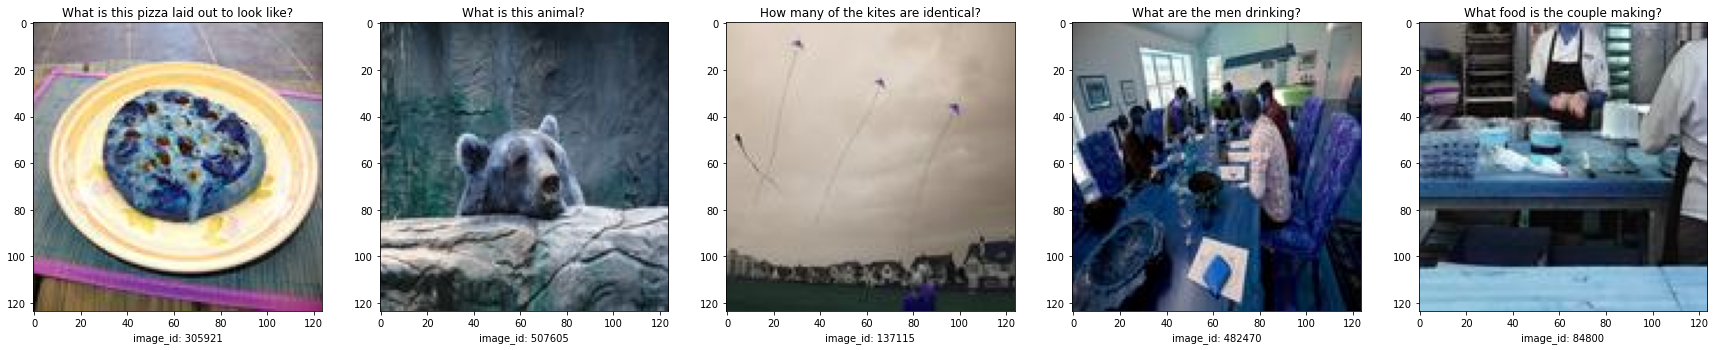

In [4]:
import json
import random
import matplotlib.pyplot as plt
import cv2

image_question = json.load(open('miniVQA/image_question.json'))
plt.figure(figsize=([30, 20]))

for i in range(5):
  plt.subplot(1, 5, i+1)
  random_image = random.choice(list(image_question.keys()))
  _, random_question = random.choice(image_question[random_image])
  plt.imshow(cv2.resize(cv2.imread('image124/'+random_image+'.jpg'), (124,124)))
  plt.xlabel('image_id: '+random_image)
  plt.title(random_question)

## **Sentence Embedding**

In [5]:
!pip install sentence_transformers

     |████████████████████████████████| 71kB 2.1MB/s 
     |████████████████████████████████| 1.1MB 6.4MB/s 
     |████████████████████████████████| 3.0MB 43.8MB/s 
     |████████████████████████████████| 890kB 43.9MB/s 
     |████████████████████████████████| 1.1MB 42.4MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.8-cp36-none-any.whl size=101996 sha256=60c421a6fe0fa1307538b3eb47dcdfb21c9a2a884bc4ea3b5a0d09d347537ad3
  Stored in directory: /root/.cache/pip/wheels/27/ec/b3/d12cc8e4daf77846db6543033d3a5642f204c0320b15945647
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=cae6bfee8374be2278b75f52dccc1d60a4b5071391951fd7876b0d92c49e3915
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [6]:
from sentence_transformers import SentenceTransformer
import time

model = SentenceTransformer('distilbert-base-nli-mean-tokens').cuda() # ne pas toucher

sentences = 'This framework generates embeddings for each input sentence word hello ok'
time_start = time.time()
sentence_embeddings = model.encode(sentences)
print(time.time()-time_start)
print(sentence_embeddings.shape)


100%|██████████| 245M/245M [00:30<00:00, 8.12MB/s]


0.12229156494140625
(768,)


In [7]:
(0.01*56000)/60

9.333333333333334

## **Creation d'un modèle**

In [ ]:
#A compléter

## **Creation d'un dataloader**

In [71]:
import pandas as pd
import csv

questionsIdImages = dict()
questionsIdQuestions = dict()
questionsEmbedded = dict()

for i in image_question.keys():
  for j in image_question[i]:
    questionId = str(j[0])
    image = str(i)
    questionsIdImages[questionId] = image
    question = str(j[1])
    questionsIdQuestions[questionId] = question
    if question not in questionsEmbedded.keys():
      questionsEmbedded[question] = model.encode(question)



In [ ]:
from torchvision.transforms import *

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, split):
        assert split in ["train","val","test"]

        self.image_dir = "image124/"
        self.file = f"miniVQA{split}.csv"

        self.images = []
        self.questions = []
        self.labels = []

        with open(self.file,encoding='utf-8-sig') as csvfile:
          csv_reader = csv.reader(csvfile)
          next(csv_reader)
          for line in csv_reader:
            questionId = line[0]
            label = line[1]
            question = questionsEmbedded.get(questionsIdQuestions.get(questionId))

            self.images.append(f"{questionsIdImages.get(questionId)}.jpg")
            self.questions.append(question)
            self.labels.append(label)

        self.transform = Compose([RandomResizedCrop((112, 112)), ToTensor()]) # Vérifier la méthode si elle fonctionne
        
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.images)

  def __getitem__(self, index):
        'Generates one sample of data'
    
        img_path = self.image_dir + self.images[index]
        img = Image.open(img_path).convert('RGB')

        img = self.transform(img)
        label = np.array(self.labels[index])
        question = np.array(self.questions[index])

        return img, question, label